<a href="https://colab.research.google.com/github/mingyeom121212/aipython/blob/main/BHF_optimizing_as_layer_depth%26tangentbolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
#신경망 모델을 nn.Module 의 하위클래스로 정의하고, __init__ 에서 신경망 계층들을
# 초기화합니다. nn.Module 을 상속받은 모든 클래스는 forward 메소드에 입력 데이터에
#대한 연산들을 구현합니다.

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Epoch [100/1000], Train Loss: 0.0393
Epoch [200/1000], Train Loss: 0.0152
Epoch [300/1000], Train Loss: 0.0089
Epoch [400/1000], Train Loss: 0.0056
Epoch [500/1000], Train Loss: 0.0042
Epoch [600/1000], Train Loss: 0.0034
Epoch [700/1000], Train Loss: 0.0085
Epoch [800/1000], Train Loss: 0.0024
Epoch [900/1000], Train Loss: 0.0020
Epoch [1000/1000], Train Loss: 0.0012


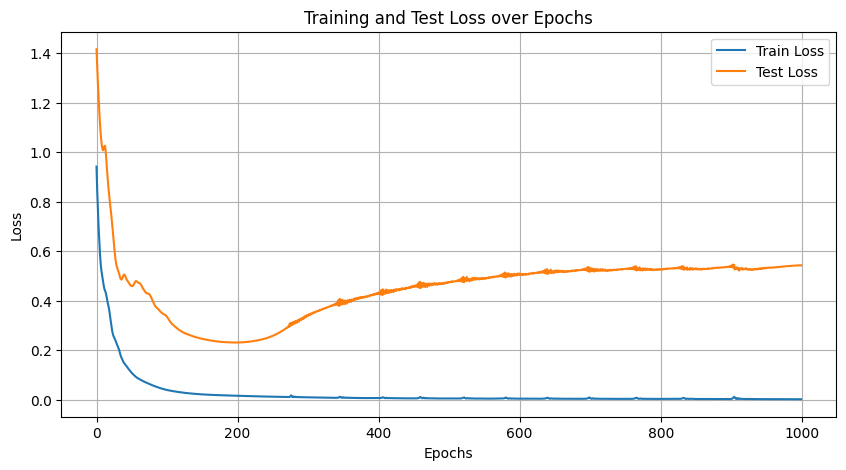

Optimization Epoch [100/1000], Loss: 0.0406
Optimization Epoch [200/1000], Loss: 0.0380
Optimization Epoch [300/1000], Loss: 0.0380
Optimization Epoch [400/1000], Loss: 0.0380
Optimization Epoch [500/1000], Loss: 0.0380
Optimization Epoch [600/1000], Loss: 0.0380
Optimization Epoch [700/1000], Loss: 0.0380
Optimization Epoch [800/1000], Loss: 0.0380
Optimization Epoch [900/1000], Loss: 0.0380
Optimization Epoch [1000/1000], Loss: 0.0380
Optimal BHF values: [[ 23931.64   32546.736 465088.25  120067.26  232079.   ]]


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('DATA2.csv')

# 특성과 타겟 분리
X = data[['BHF1', 'BHF2', 'BHF3', 'BHF4', 'BHF5']].values
y = data[['W2', 'W4', 'Crack']].values

# 데이터 표준화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 20)  # 입력 5, 출력 20
        self.fc2 = nn.Linear(20, 20)  # 입력 20, 출력 20
        self.fc3 = nn.Linear(20, 10)  # 입력 20, 출력 10
        self.fc4 = nn.Linear(10, 3)   # 입력 10, 출력 3
        self.tanh = nn.Tanh()         # Tanh 활성화 함수

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()

# 손실 함수 및 최적화 방법 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # 초기 학습률 0.01

# 모델 학습
num_epochs = 1000
train_losses = []  # 학습 손실 기록 리스트
test_losses = []   # 테스트 손실 기록 리스트

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())  # 학습 손실 기록

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # 모델 평가
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test)
        test_losses.append(test_loss.item())  # 테스트 손실 기록
    model.train()

# 시각화: 손실 변화 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 최적의 BHF 값을 찾기 위한 최적화
BHF_initial = torch.tensor(scaler_X.transform([[0, 0, 0, 0, 0]]), dtype=torch.float32, requires_grad=True)
optimizer = optim.Adam([BHF_initial], lr=0.01)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(BHF_initial)
    loss = criterion(outputs, torch.tensor([[0, 0, 0]], dtype=torch.float32))  # 목표 W2, W4, Crack 값
    loss.backward()
    optimizer.step()

    # BHF 값을 음수가 되지 않도록 클램핑
    with torch.no_grad():
        BHF_initial.clamp_(min=0.0)

    if (epoch+1) % 100 == 0:
        print(f'Optimization Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

optimal_BHF = scaler_X.inverse_transform(BHF_initial.detach().numpy())
print(f'Optimal BHF values: {optimal_BHF}')


Epoch [100/1000], Train Loss: 0.0855
Epoch [200/1000], Train Loss: 0.0393
Epoch [300/1000], Train Loss: 0.0159
Epoch [400/1000], Train Loss: 0.0100
Epoch [500/1000], Train Loss: 0.0075
Epoch [600/1000], Train Loss: 0.0062
Epoch [700/1000], Train Loss: 0.0056
Epoch [800/1000], Train Loss: 0.0051
Epoch [900/1000], Train Loss: 0.0047
Epoch [1000/1000], Train Loss: 0.0044


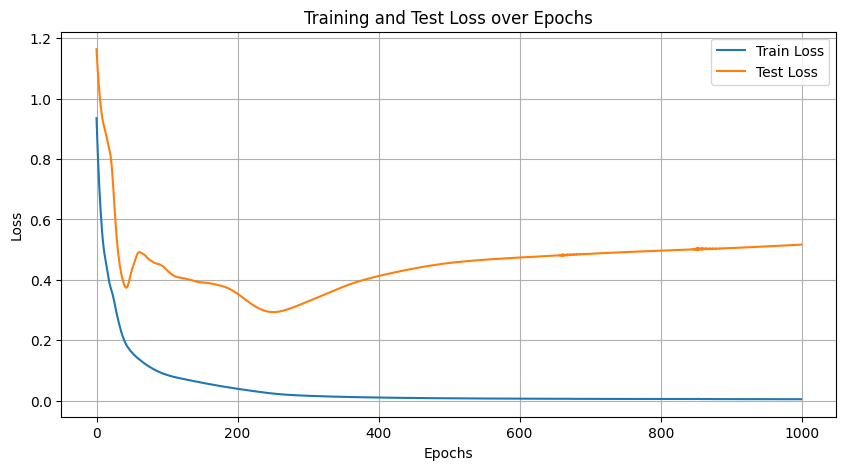

Optimization Epoch [100/1000], Loss: 0.0051
Optimization Epoch [200/1000], Loss: 0.0037
Optimization Epoch [300/1000], Loss: 0.0023
Optimization Epoch [400/1000], Loss: 0.0012
Optimization Epoch [500/1000], Loss: 0.0005
Optimization Epoch [600/1000], Loss: 0.0002
Optimization Epoch [700/1000], Loss: 0.0000
Optimization Epoch [800/1000], Loss: 0.0000
Optimization Epoch [900/1000], Loss: 0.0000
Optimization Epoch [1000/1000], Loss: 0.0000
Optimal BHF values: [[ 23931.64   32546.736 442819.    125607.83  258016.34 ]]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('DATA2.csv')

# 특성과 타겟 분리
X = data[['BHF1', 'BHF2', 'BHF3', 'BHF4', 'BHF5']].values
y = data[['W2', 'W4', 'Crack']].values

# 데이터 표준화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 10)  # 입력 5, 출력 10
        self.fc2 = nn.Linear(10, 10)  # 입력 10, 출력 10
        self.fc3 = nn.Linear(10, 3)   # 입력 10, 출력 3
        self.tanh = nn.Tanh()         # Tanh 활성화 함수

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

# 손실 함수 및 최적화 방법 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # 초기 학습률 0.01

# 모델 학습
num_epochs = 1000
train_losses = []  # 학습 손실 기록 리스트
test_losses = []   # 테스트 손실 기록 리스트

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())  # 학습 손실 기록

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # 모델 평가
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test)
        test_losses.append(test_loss.item())  # 테스트 손실 기록
    model.train()

# 시각화: 손실 변화 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 최적의 BHF 값을 찾기 위한 최적화
BHF_initial = torch.tensor(scaler_X.transform([[0, 0, 0, 0, 0]]), dtype=torch.float32, requires_grad=True)
optimizer = optim.Adam([BHF_initial], lr=0.01)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(BHF_initial)
    loss = criterion(outputs, torch.tensor([[0, 0, 0]], dtype=torch.float32))  # 목표 W2, W4, Crack 값
    loss.backward()
    optimizer.step()

    # BHF 값을 음수가 되지 않도록 클램핑
    with torch.no_grad():
        BHF_initial.clamp_(min=0.0)

    if (epoch+1) % 100 == 0:
        print(f'Optimization Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

optimal_BHF = scaler_X.inverse_transform(BHF_initial.detach().numpy())
print(f'Optimal BHF values: {optimal_BHF}')


Epoch [100/1000], Train Loss: 0.0786
Epoch [200/1000], Train Loss: 0.0205
Epoch [300/1000], Train Loss: 0.0126
Epoch [400/1000], Train Loss: 0.0091
Epoch [500/1000], Train Loss: 0.0073
Epoch [600/1000], Train Loss: 0.0048
Epoch [700/1000], Train Loss: 0.0031
Epoch [800/1000], Train Loss: 0.0024
Epoch [900/1000], Train Loss: 0.0021
Epoch [1000/1000], Train Loss: 0.0020


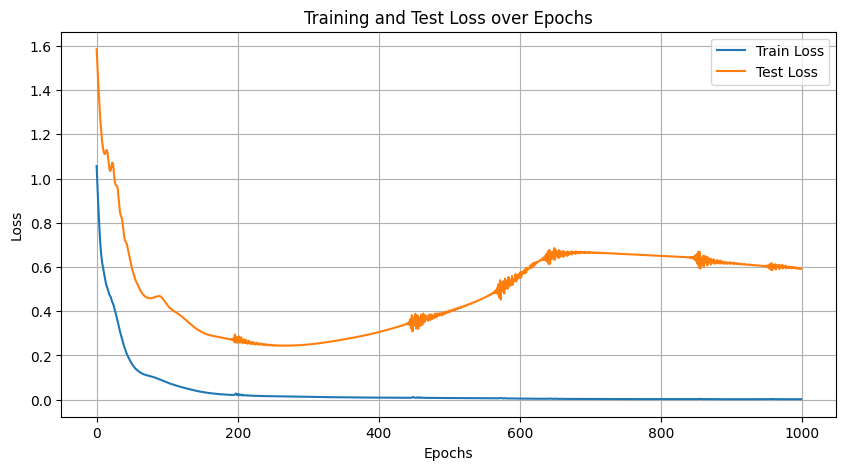

Optimization Epoch [100/1000], Loss: 0.2977
Optimization Epoch [200/1000], Loss: 0.2755
Optimization Epoch [300/1000], Loss: 0.2716
Optimization Epoch [400/1000], Loss: 0.2706
Optimization Epoch [500/1000], Loss: 0.2702
Optimization Epoch [600/1000], Loss: 0.2702
Optimization Epoch [700/1000], Loss: 0.2702
Optimization Epoch [800/1000], Loss: 0.2702
Optimization Epoch [900/1000], Loss: 0.2701
Optimization Epoch [1000/1000], Loss: 0.2700
Optimal BHF values: [[ 25919.625  40161.445 477370.44  112465.11  232079.   ]]


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_csv('DATA2.csv')

# 특성과 타겟 분리
X = data[['BHF1', 'BHF2', 'BHF3', 'BHF4', 'BHF5']].values
y = data[['W2', 'W4', 'Crack']].values

# 데이터 표준화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 10)  # 입력 5, 출력 20
        self.fc2 = nn.Linear(10, 20)  # 입력 20, 출력 20
        self.fc3 = nn.Linear(20, 10)  # 입력 20, 출력 10
        self.fc4 = nn.Linear(10, 5)
        self.fc5 = nn.Linear(5, 3)   # 입력 10, 출력 3
        self.tanh = nn.Tanh()         # Tanh 활성화 함수

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

model = Net()

# 손실 함수 및 최적화 방법 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # 초기 학습률 0.01

# 모델 학습
num_epochs = 1000
train_losses = []  # 학습 손실 기록 리스트
test_losses = []   # 테스트 손실 기록 리스트

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())  # 학습 손실 기록

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    # 모델 평가
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        test_loss = criterion(outputs, y_test)
        test_losses.append(test_loss.item())  # 테스트 손실 기록
    model.train()

# 시각화: 손실 변화 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 최적의 BHF 값을 찾기 위한 최적화
BHF_initial = torch.tensor(scaler_X.transform([[0, 0, 0, 0, 0]]), dtype=torch.float32, requires_grad=True)
optimizer = optim.Adam([BHF_initial], lr=0.01)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(BHF_initial)
    loss = criterion(outputs, torch.tensor([[0, 0, 0]], dtype=torch.float32))  # 목표 W2, W4, Crack 값
    loss.backward()
    optimizer.step()

    # BHF 값을 음수가 되지 않도록 클램핑
    with torch.no_grad():
        BHF_initial.clamp_(min=0.0)

    if (epoch+1) % 100 == 0:
        print(f'Optimization Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

optimal_BHF = scaler_X.inverse_transform(BHF_initial.detach().numpy())
print(f'Optimal BHF values: {optimal_BHF}')
